In [91]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
import pickle
with open("/content/images_to_text_dict.pickle", 'rb') as f:
    idx_text = pickle.load(f)

In [93]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [94]:
from transformers import BertTokenizer, BertModel
from transformers import logging
logging.set_verbosity_error()


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [95]:
import numpy as np
embeddings_TfI = {}

p = 0
for key in idx_text.keys():
    name = key.rsplit(".", 1)[0]
    p += 1
    value = idx_text[key][0]
    input_ids = tokenizer.encode(value, return_tensors='pt', truncation=True, pad_to_max_length=True)
    outputs = model(input_ids)

    # Extract the last hidden state of the model
    embedding = outputs[0][:, 0, :]
    embeddings_TfI[name] = embedding 
    if p % 100 == 0:
      print(len(embeddings_TfI.keys()))
      name = "emb_"+str(p // 100)+".pickle"
      with open(name, 'wb') as f:
      # Use the dump() function to write the list to the file
        pickle.dump(embeddings_TfI, f)
      embeddings_TfI = {}
name = "emb_"+str((p // 100)+1)+".pickle"
with open(name, 'wb') as f:
      # Use the dump() function to write the list to the file
  pickle.dump(embeddings_TfI, f)
      

100
100
100
100
100


In [96]:
with open('/content/emb_1.pickle', 'rb') as f:
    emb1 = pickle.load(f)


In [97]:
with open('/content/emb_2.pickle', 'rb') as f:
    emb2 = pickle.load(f)

In [98]:
with open('/content/emb_3.pickle', 'rb') as f:
    emb3 = pickle.load(f)

In [99]:
with open('/content/emb_4.pickle', 'rb') as f:
    emb4 = pickle.load(f)

In [100]:
print(emb1['00d0583684114'].shape)

torch.Size([1, 768])


In [101]:
with open('/content/emb_5.pickle', 'rb') as f:
    emb5 = pickle.load(f)

In [102]:
with open('/content/emb_6.pickle', 'rb') as f:
    emb6 = pickle.load(f)

In [103]:
with open("/content/one_sentence.pickle", 'rb') as f:
    bad_users_dict = pickle.load(f)

In [104]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

In [105]:
emb = emb1
emb.update(emb2)
emb.update(emb3)
emb.update(emb4)
emb.update(emb5)
emb.update(emb6)

In [106]:
good_users_dict = {}
for img in bad_users_dict.keys():
  if img in emb:
    good_users_dict[img] = bad_users_dict[img]

In [107]:
deviceGPU = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [108]:
# Load training data
# Define mapping images -> labels
images2labels = {}
labels2images = {}
for (i, img) in enumerate(good_users_dict.keys()):
  images2labels[img] = i
  labels2images[i] = img
  # Move data to GPU
  emb[img] = emb[img].detach().numpy()
  good_users_dict[img] = good_users_dict[img].detach().numpy()


data = emb[labels2images[0]]
for i in range(1, len(images2labels)):
  data = np.concatenate((data, emb[labels2images[i]]), axis=0)

In [109]:
type(emb)

dict

In [110]:
idx_combs = []
# False combs
for i in range(len(good_users_dict)):
  for j in range(i, len(good_users_dict)):
    idx_combs.append((i, j))

#add positive examples
for i in range(len(good_users_dict)):
  for _dummy in range(30):
    idx_combs.append((i, i))

In [111]:
from transformers.models.prophetnet.modeling_prophetnet import dataclass
# Seperate training embeddings to training set and validation set
train_size = int(len(idx_combs)*0.8)
train_set = idx_combs[:train_size]
valid_set = idx_combs[train_size:]

# labels = data
# train_labels = labels[:train_size]
# valid_labels = labels[train_size:]

In [112]:
torch.manual_seed(2023)
import torch.nn as nn

class Embeddings_MLP_Autoencoder(torch.nn.Module):
    
    '''
    Builds MLP autoencoder for embeddings Dataset.
    
    encoder_layer_dims - list of integers representing dimensions of encoder's hidden layers. Last value of the list represents the 
    dimension of the encoder output
    encoder_activations - list of Pytorch activations functions to apply to each of the encoder's hidden layers. List must be the 
    same length as encoder_layer_dims
    decoder_layer_dims - list of integers representing dimensions of decoder's hidden layers. This list does not include the output dimension
    decoder_activations - list of Pytorch activations functions to apply to each of the decoder's hidden layers. List must be the 
    same length as decoder_layer_dims
    in_out_dim - integer represting dimension of the input and output. Defaults to 768. 
    '''
    
    def __init__(self, encoder_layer_dims, encoder_activations, decoder_layer_dims, decoder_activations, 
                 output_activation, in_out_dim = 768):
        
        super().__init__()
        
        # Build the first layer of encoder
        encoder_layers = []
        encoder_layers.append(torch.nn.Linear(in_features = in_out_dim, out_features = encoder_layer_dims[0], bias = True))
        encoder_layers.append(encoder_activations[0])
        
        # Build rest of the layers of encoder
        for i in range(len(encoder_layer_dims) - 1):
            
            encoder_layers.append(torch.nn.Linear(in_features = encoder_layer_dims[i], out_features = encoder_layer_dims[i + 1], bias = True))
            encoder_layers.append(encoder_activations[i + 1])
        
        # Stack the encoder layers
        self.encoder = torch.nn.Sequential(*encoder_layers)
        
        # # Build the first layer of decoder
        # decoder_layers = []
        # decoder_layers.append(torch.nn.Linear(in_features = encoder_layer_dims[-1], out_features = decoder_layer_dims[0], bias = True))
        # decoder_layers.append(decoder_activations[0])
        
        # # Build rest of the layers of decoder
        # for i in range(len(decoder_activations) - 1):
            
        #     decoder_layers.append(torch.nn.Linear(in_features = decoder_layer_dims[i], out_features = decoder_layer_dims[i + 1], bias = True))
        #     decoder_layers.append(decoder_activations[i + 1])
        
        # # Build output layer
        # decoder_layers.append(torch.nn.Linear(in_features = decoder_layer_dims[-1], out_features = in_out_dim, bias = True))
        # decoder_layers.append(output_activation)
        
        # # Stack the decoder layers
        # self.decoder = torch.nn.Sequential(*decoder_layers)
        
    def encode(self, data):
        # Forward propogation for the encoder
        return self.encoder(data).to(deviceGPU)
    
    # def decode(self, encoded):
    #     # Forward propogation of the decoder 
    #     return self.decoder(encoded).to(deviceGPU)
        
    def forward(self, data):
        # Forward propogation for entire network 
        #data = nn.Dropout(p=0.4)(data)
        encoded = self.encode(data).to(deviceGPU)
        #decoded = self.decode(encoded).to(deviceGPU)
        
        return encoded#, decoded

In [113]:
class Full_NN(torch.nn.Module):
    
    '''
    Builds MLP autoencoder for embeddings Dataset.
    
    encoder_layer_dims - list of integers representing dimensions of encoder's hidden layers. Last value of the list represents the 
    dimension of the encoder output
    encoder_activations - list of Pytorch activations functions to apply to each of the encoder's hidden layers. List must be the 
    same length as encoder_layer_dims
    decoder_layer_dims - list of integers representing dimensions of decoder's hidden layers. This list does not include the output dimension
    decoder_activations - list of Pytorch activations functions to apply to each of the decoder's hidden layers. List must be the 
    same length as decoder_layer_dims
    in_out_dim - integer represting dimension of the input and output. Defaults to 768. 
    '''
    
    def __init__(self, first_ae, second_ae, layer_dims, similarity_activations, in_dim = 30):
        
        super().__init__()
        
        # Build the first layer of encoder
        mlp_layers = []
        # mlp_layers.append(torch.nn.Linear(in_features = in_dim, out_features = layer_dims[0], bias = True))
        # mlp_layers.append(similarity_activations[0])
        
        # # Build rest of the layers of encoder
        # for i in range(len(layer_dims) - 1):
            
        #     mlp_layers.append(torch.nn.Linear(in_features = layer_dims[i], out_features = layer_dims[i + 1], bias = True))
        #     mlp_layers.append(similarity_activations[i + 1])

        #Sigmod
        mlp_layers.append(torch.nn.Sigmoid())
        
        # Stack the encoder layers
        self.mlp = torch.nn.Sequential(*mlp_layers)


        
        #AutoEncoders
        self.first_ae = first_ae
        self.second_ae = second_ae
        
        
        
    def forward(self, ocr_batch, user_batch):
        # Forward propogation for entire network 
        #data = nn.Dropout(p=0.4)(data)
        # print("Pair", pair_idx)
        # print("Pair_type", type(pair_idx))
        
        # first_key = labels2images[pair_idx[0][0]]
        # print("First key", first_key)
        # first_actual = emb[first_key]
        # second_actual = emb[labels2images[pair_idx[0][1]]]
        ocr_encoded = self.first_ae(ocr_batch)
        user_encoded = self.second_ae(user_batch)#change embedding

        euclidean_distances = torch.norm(torch.sub(ocr_encoded, user_encoded), p = 2, dim = 1)

        #print("Ocr_encoded", ocr_encoded)
        # ocr_mlp_result = self.mlp(ocr_encoded).to(deviceGPU)
        
        # #print("user_encoded", ocr_encoded)
        # user_mlp_result = self.mlp(user_encoded).to(deviceGPU)

        result = self.mlp(euclidean_distances)


        return result

  

In [125]:
autoencoderOCR = Embeddings_MLP_Autoencoder([196, 100, 50, 30, 15], [torch.nn.ReLU(), torch.nn.ReLU(), torch.nn.ReLU(), torch.nn.ReLU(), torch.nn.ReLU()], [50,100, 196], 
                                            [torch.nn.ReLU(), torch.nn.ReLU(), torch.nn.ReLU()], torch.nn.ReLU(), in_out_dim = 768).to(deviceGPU)

#change the dimensions with the right embeddings
autoencoderUser = Embeddings_MLP_Autoencoder([196, 100, 50, 30, 15], [torch.nn.ReLU(), torch.nn.ReLU(), torch.nn.ReLU(), torch.nn.ReLU(), torch.nn.ReLU()], [50,100, 196], 
                                            [torch.nn.ReLU(), torch.nn.ReLU(), torch.nn.ReLU()], torch.nn.ReLU(), in_out_dim = 768).to(deviceGPU)
myNeuralNet = Full_NN(autoencoderOCR, autoencoderUser, layer_dims = [30,20,10], similarity_activations = [torch.nn.ReLU(), torch.nn.ReLU(), torch.nn.ReLU()]).to(deviceGPU)

In [126]:

mse_loss = torch.nn.MSELoss(reduction = 'sum')
cosine_sim = torch.nn.CosineSimilarity(dim=1)
#For sigmoid
criterion = torch.nn.BCELoss()

In [127]:
tensor1 = torch.randn(100, 20)
tensor2 = torch.randn(100, 20)
# Instantiate the CosineSimilarity module

# Calculate the cosine similarity between the two tensors
similarity = cosine_sim(tensor1, tensor2)

print(similarity)

tensor([-0.3748, -0.0416,  0.1336,  0.0513, -0.2871, -0.0533, -0.1155,  0.3678,
         0.2523, -0.0207,  0.0034, -0.3734,  0.1286, -0.1348, -0.1150,  0.2861,
        -0.0596,  0.1684, -0.1244, -0.1409,  0.0075, -0.4695,  0.2291, -0.2793,
        -0.2586,  0.1638, -0.1824, -0.1612, -0.1710, -0.1955, -0.3173, -0.3017,
        -0.0472, -0.2335,  0.1134, -0.2764,  0.1155,  0.3164,  0.0218, -0.1743,
        -0.2558,  0.3201,  0.5215,  0.0253,  0.1558, -0.3717, -0.3680, -0.0521,
         0.2781,  0.3062,  0.2313, -0.3929, -0.2276,  0.4469,  0.1013,  0.0320,
         0.2571, -0.0434, -0.1743,  0.0247, -0.1332,  0.0215,  0.0600,  0.0526,
         0.0028, -0.1018,  0.0727, -0.1686,  0.3251, -0.3826,  0.0137, -0.0617,
        -0.3718,  0.3246, -0.2387,  0.0024,  0.1725,  0.1679, -0.0687, -0.2822,
         0.0227,  0.2329, -0.2621, -0.2564,  0.0153,  0.3037, -0.2339, -0.0513,
         0.2285,  0.2419,  0.0818, -0.0286, -0.1349, -0.2127, -0.0877, -0.1764,
         0.0327,  0.2099, -0.3426, -0.09

In [128]:

def show_non_zeros(cosine_similarity):
  print("Printing non zeros")
  m = cosine_similarity.size()[0]
  print("m", m)
  for i in range(m):
    if (cosine_similarity[i] != 0):
      print(cosine_similarity[i])

In [129]:

def autoencoder_similarity_loss(output, true_label, alpha = 0.1):
  # first_mse = 1/first_actual.size()[0] * mse_loss(first_decoded, first_actual)
  # second_mse = 1/second_actual.size()[0] * mse_loss(second_decoded, second_actual)

  # first_mlp = torch.mul(torch.nn.functional.normalize(first_mlp), 100)
  # second_mlp = torch.mul(torch.nn.functional.normalize(second_mlp), 100)



  # cosine_similarity = cosine_sim(first_mlp, second_mlp)

  # cosine_similarity = -cosine_similarity

  #res_cos = -res_cos



  same_label = torch.add(torch.mul(same_label.long(), 2), -1)

  similarity_loss = torch.sum(torch.abs(torch.add(same_label, cosine_similarity)))/same_label.size()[0]

  # print("First ae", first_mse)
  # print("Second ae", second_mse)
  # print("similarity", 10000000*similarity_loss)
  return first_mse + second_mse + 1000*similarity_loss

full_num_epochs = 30
full_batch_size = 100
full_training_size = len(train_set)
full_optimizer = torch.optim.Adam(myNeuralNet.parameters(), lr = 0.001)
#lam = 0.001

In [130]:

# Training and validation loss for training
full_training_loss = []
full_validation_loss = []


for i in range(full_num_epochs):
    
    train_epoch_loss = []
    
    myNeuralNet.train()
    full_batch_start = 0
    
    while full_batch_start < full_training_size:
        
        full_batch_end = full_batch_start + full_batch_size
        
        # Get batch of corrupted input and true image
        corrupted_batch = train_set[full_batch_start:full_batch_end]
        training_batch = train_set[full_batch_start:full_batch_end]
        

        #change to user embeddings
        user_actual = torch.tensor(np.array(list(map(lambda x: good_users_dict[labels2images[x[0]]], corrupted_batch)))).view(-1,768).to(deviceGPU)
        ocr_actual = torch.tensor(np.array(list(map(lambda x: emb[labels2images[x[1]]], corrupted_batch)))).view(-1,768).to(deviceGPU)
        same_label = torch.tensor(np.array(list(map(lambda x: x[0] == x[1], corrupted_batch)))).view(-1).to(deviceGPU)

        #print("user ", user)
        #print("user size", user_actual.size())
        # print("ocr ", ocr)
        #print("same_label", same_label.size())

        result = myNeuralNet(ocr_actual.cuda(), user_actual.cuda())
        #print(ocr_mlp_result.size())
        #full_loss = autoencoder_similarity_loss(ocr_decoded, ocr_actual, user_decoded, user_actual, ocr_mlp_result, user_mlp_result, same_label)

        #print(same_label.float())
        full_loss = criterion(result, same_label.float())
        #print(full_loss)
        train_epoch_loss.append(full_loss.item()/len(corrupted_batch))
        
        # Backpropogation and gradient descent 
        full_optimizer.zero_grad()
        full_loss.backward()
        full_optimizer.step()
        
        full_batch_start = full_batch_end

    myNeuralNet.eval()
    
    with torch.no_grad():
        
        # Input validation set into autoencoder and obtain metrics 

        user_actual = torch.tensor(np.array(list(map(lambda x: good_users_dict[labels2images[x[0]]], valid_set)))).view(-1,768).to(deviceGPU)
        ocr_actual = torch.tensor(np.array(list(map(lambda x: emb[labels2images[x[1]]], valid_set)))).view(-1,768).to(deviceGPU)
        same_label = torch.tensor(np.array(list(map(lambda x: x[0] == x[1], valid_set)))).view(-1).to(deviceGPU)

        #print()
        
        # ocr_mlp_result, user_mlp_result, ocr_decoded, user_decoded, ocr_encoded, user_encoded = myNeuralNet(ocr_actual.cuda(), user_actual.cuda())
        
        # full_val_loss = autoencoder_similarity_loss(ocr_decoded, ocr_actual, user_decoded, user_actual, ocr_mlp_result, user_mlp_result, same_label).item()
        
        result = myNeuralNet(ocr_actual.cuda(), user_actual.cuda())
        full_val_loss = criterion(result, same_label.float())

    full_epoch_training_loss = np.sum(train_epoch_loss)/full_training_size
    
    full_training_loss.append(full_epoch_training_loss)
    full_validation_loss.append(full_val_loss)
    
    # Print out metrics for every 20 epochs 
    if i % 1 == 0 or i == full_num_epochs - 1:
        full_status = f'Epoch {i}: \nValidation Loss: {full_val_loss} \nTraining Loss: {full_epoch_training_loss}\n' 
        print(full_status)
     

Epoch 0: 
Validation Loss: 0.6931077241897583 
Training Loss: 6.967240285988897e-05

Epoch 1: 
Validation Loss: 0.6931334733963013 
Training Loss: 6.937491890861698e-05

Epoch 2: 
Validation Loss: 0.6931020617485046 
Training Loss: 6.935633303229661e-05

Epoch 3: 
Validation Loss: 0.6930397748947144 
Training Loss: 6.935520461400836e-05

Epoch 4: 
Validation Loss: 0.6931033730506897 
Training Loss: 6.935050559550243e-05

Epoch 5: 
Validation Loss: 0.6930993795394897 
Training Loss: 6.934331224116554e-05

Epoch 6: 
Validation Loss: 0.6929978728294373 
Training Loss: 6.934820508273465e-05

Epoch 7: 
Validation Loss: 0.6930870413780212 
Training Loss: 6.934434874352691e-05

Epoch 8: 
Validation Loss: 0.6931257247924805 
Training Loss: 6.93472453943875e-05

Epoch 9: 
Validation Loss: 0.6930730938911438 
Training Loss: 6.934509271675855e-05

Epoch 10: 
Validation Loss: 0.6931310892105103 
Training Loss: 6.93450381204349e-05



KeyboardInterrupt: ignored

In [ ]:
print(full_training_loss)
print(full_validation_loss)

[1226.8659225439249, 1210.7436566443948, 1209.1970032170257, 1203.5300868596883, 1197.6775717644148, 1189.44940806731, 1184.908450631032, 1177.1133494184608, 1169.4172326156893, 1163.4781101212573, 1157.3038945805492, 1152.9361667903984, 1149.9542331106163, 1144.0398520168276, 1139.313300915615, 1134.599121133383, 1130.7139434545904, 1128.7342318732988, 1127.6206453848058, 1122.2135700321703, 1117.9200794357832, 1115.532058401386, 1115.5320580301907, 1115.5320575352634, 1115.5320566691414, 1115.5320341499628, 1114.8638688443457, 1113.304846325167, 1113.0821280623609, 1112.9460225191783]
[11590486.0, 11590486.0, 11590486.0, 11517731.0, 11482097.0, 11449431.0, 11362820.0, 11283631.0, 11283631.0, 11283631.0, 11203947.0, 11145547.0, 11061409.0, 11061409.0, 10954999.0, 10903527.0, 10903527.0, 10903527.0, 10849085.0, 10779300.0, 10779300.0, 10779300.0, 10779300.0, 10779300.0, 10779300.0, 10779299.0, 10779299.0, 10779299.0, 10779299.0, 10779299.0]


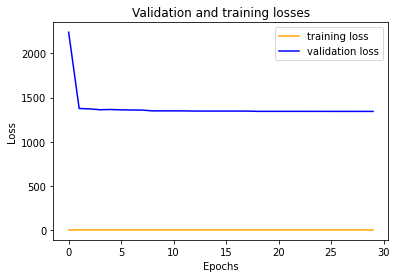

In [ ]:
import matplotlib.pyplot as plt 

m1 = int(np.mean(np.array(full_validation_loss))/np.mean(np.array(full_training_loss)))
for i in range(len(full_training_loss)):
  full_training_loss[i] = full_training_loss[i]
plt.plot(full_training_loss, color='orange')
plt.plot(full_validation_loss, color='blue')
plt.legend(['training loss', 'validation loss'])
plt.title("Validation and training losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
corrupted_batch = valid_set
        

user_actual = torch.tensor(np.array(list(map(lambda x: good_users_dict[labels2images[x[0]]], corrupted_batch)))).view(-1,768).to(deviceGPU)
ocr_actual = torch.tensor(np.array(list(map(lambda x: emb[labels2images[x[1]]], corrupted_batch)))).view(-1,768).to(deviceGPU)
same_label = torch.tensor(np.array(list(map(lambda x: x[0] == x[1], corrupted_batch)))).view(-1).to(deviceGPU)


ocr_mlp_result, user_mlp_result, ocr_decoded, user_decoded, ocr_encoded, user_encoded = myNeuralNet(ocr_actual.cuda(), user_actual.cuda())

print(ocr_encoded.size(), user_encoded.size())

torch.Size([20205, 3]) torch.Size([20205, 3])


In [ ]:
ocr_encoded[100:300]


tensor([[ 3.0578,  0.0000, 23.9334],
        [ 0.0000,  0.0000, 26.3519],
        [ 6.5697,  0.0000, 23.3795],
        [ 7.2895,  0.0000, 19.7003],
        [ 0.0000,  0.0000, 25.0846],
        [12.9113,  0.0000, 22.0340],
        [ 5.8896,  0.0000, 28.4948],
        [ 2.7083,  0.0000, 23.1306],
        [ 0.2798,  0.0000, 24.6334],
        [ 0.0000,  0.0000, 22.6237],
        [ 0.0000,  0.0000, 25.5063],
        [ 5.1833,  0.0000, 19.6678],
        [ 8.4478,  0.0000, 24.1105],
        [ 3.2336,  0.0000, 21.9637],
        [ 3.5196,  0.0000, 24.0845],
        [ 1.3575,  0.0000, 23.5880],
        [ 7.6472,  0.0000, 25.9245],
        [ 6.6637,  0.0000, 21.2292],
        [ 6.0603,  0.0000, 22.0029],
        [ 3.5457,  0.0000, 22.7888],
        [ 1.5228,  0.0000, 24.8763],
        [ 6.1254,  0.0000, 24.2047],
        [ 2.8012,  0.0000, 23.8424],
        [ 6.1828,  0.0000, 21.8396],
        [11.0482,  0.0000, 23.3819],
        [24.2179,  0.0000,  0.0000],
        [ 5.0126,  0.0000, 22.1274],
 

In [ ]:
print(user_encoded)

tensor([[5.3146, 4.2288, 0.0000],
        [5.3146, 4.2288, 0.0000],
        [5.3146, 4.2288, 0.0000],
        ...,
        [4.2902, 3.6790, 0.0000],
        [4.2902, 3.6790, 0.0000],
        [4.7873, 3.9934, 0.0000]], device='cuda:0', grad_fn=<ReluBackward0>)


In [ ]:
print(len(valid_set))
print(valid_set)

20205
[(248, 344), (248, 345), (248, 346), (248, 347), (248, 348), (248, 349), (248, 350), (248, 351), (248, 352), (248, 353), (248, 354), (248, 355), (248, 356), (248, 357), (248, 358), (248, 359), (248, 360), (248, 361), (248, 362), (248, 363), (248, 364), (248, 365), (248, 366), (248, 367), (248, 368), (248, 369), (248, 370), (248, 371), (248, 372), (248, 373), (248, 374), (248, 375), (248, 376), (248, 377), (248, 378), (248, 379), (248, 380), (248, 381), (248, 382), (248, 383), (248, 384), (248, 385), (248, 386), (248, 387), (248, 388), (248, 389), (248, 390), (248, 391), (248, 392), (248, 393), (248, 394), (248, 395), (248, 396), (248, 397), (248, 398), (248, 399), (248, 400), (248, 401), (248, 402), (248, 403), (248, 404), (248, 405), (248, 406), (248, 407), (248, 408), (248, 409), (248, 410), (248, 411), (248, 412), (248, 413), (248, 414), (248, 415), (248, 416), (248, 417), (248, 418), (248, 419), (248, 420), (248, 421), (248, 422), (248, 423), (248, 424), (248, 425), (248, 426

In [ ]:
id2ocr = {}
ocr2id = {}
id2user = {}
user2id = {}
ids2emb = {}

In [ ]:
import copy
for (i, tup) in enumerate(valid_set):
  (ocrID, userID) = copy.deepcopy(tup)
  id2ocr[ocrID] = ocr_encoded[i].clone()
  ids2emb[tup] = (ocr_encoded[i].clone(), user_encoded[i].clone())
  # ocr2id[ocr_encoded[i]] = ocrID
  #id2user[userID] = user_encoded[i].clone()
  # user2id[user_encoded[i]] = userID

In [ ]:
len(ids2emb)

20205

In [ ]:
firsts = []
for i in range(len(valid_set)):
  firsts.append(valid_set[i][0])
firsts = list(set(firsts))
print(firsts)

[248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447,

In [ ]:

def mp(fixed_id1):
  # fixed_id1 = 431
  distances = {}
  for i in range(len(valid_set)):
    (id1, id2) = valid_set[i]
    if (id1 == fixed_id1):
      embs = ids2emb[(id1, id2)]
      distances[id2] = cosine_sim(embs[0].view(-1, 3), embs[1].view(-1, 3))
  predictedID = min(distances, key=lambda k: distances[k])
  # print(predictedID)
  # print(predictedID == fixed_id1)
  return predictedID == fixed_id1

In [ ]:
all = []
count = 0
for id_user in firsts:

  all.append(mp(id_user))
print(sum(all)/len(firsts)*100)


5.970149253731343


In [ ]:
print((id1, id2))

(248, 344)


In [ ]:
print(ids2emb[(id1, id2)])

(tensor([6.8409, 5.0500, 0.8995, 2.6585, 3.5563, 0.1027, 0.0000],
       device='cuda:0', grad_fn=<CloneBackward0>), tensor([  0.0000,   0.0000,   0.0000,   0.0000,   0.0000, 171.5797,   0.0000],
       device='cuda:0', grad_fn=<CloneBackward0>))


In [ ]:
# valid_set

low_data1, low_data2 = autoencoderOCR.encode(torch.Tensor(valid_set).to(deviceGPU))
print(low_data.size())
print(low_data[0])

RuntimeError: ignored

In [ ]:
print(valid_set)

[(248, 344), (248, 345), (248, 346), (248, 347), (248, 348), (248, 349), (248, 350), (248, 351), (248, 352), (248, 353), (248, 354), (248, 355), (248, 356), (248, 357), (248, 358), (248, 359), (248, 360), (248, 361), (248, 362), (248, 363), (248, 364), (248, 365), (248, 366), (248, 367), (248, 368), (248, 369), (248, 370), (248, 371), (248, 372), (248, 373), (248, 374), (248, 375), (248, 376), (248, 377), (248, 378), (248, 379), (248, 380), (248, 381), (248, 382), (248, 383), (248, 384), (248, 385), (248, 386), (248, 387), (248, 388), (248, 389), (248, 390), (248, 391), (248, 392), (248, 393), (248, 394), (248, 395), (248, 396), (248, 397), (248, 398), (248, 399), (248, 400), (248, 401), (248, 402), (248, 403), (248, 404), (248, 405), (248, 406), (248, 407), (248, 408), (248, 409), (248, 410), (248, 411), (248, 412), (248, 413), (248, 414), (248, 415), (248, 416), (248, 417), (248, 418), (248, 419), (248, 420), (248, 421), (248, 422), (248, 423), (248, 424), (248, 425), (248, 426), (24

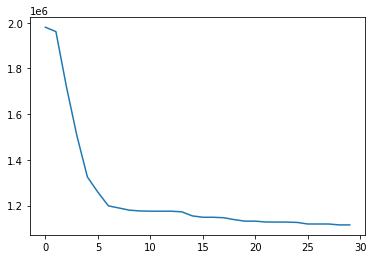

In [ ]:
plt.plot(full_validation_loss)

In [ ]:

# Training and validation loss for training
ae_training_loss = []
ae_validation_loss = []


for i in range(ae_num_epochs):
    
    train_epoch_loss = []
    
    autoencoderOCR.train()
    ae_batch_start = 0
    
    while ae_batch_start < ae_training_size:
        
        ae_batch_end = ae_batch_start + ae_batch_size
        
        # Get batch of corrupted input and true image
        corrupted_batch = train_set[ae_batch_start:ae_batch_end]
        training_batch = train_set[ae_batch_start:ae_batch_end]
        
        # Run through autoencoder and calculate loss
        encoded, decoded = autoencoderOCR(corrupted_batch)
        ae_loss = sparse_autoencoder_loss(encoded, decoded, training_batch, lam)
        
        train_epoch_loss.append(ae_loss.item() * corrupted_batch.size()[0])
        
        # Backpropogation and gradient descent 
        ae_optimizer.zero_grad()
        ae_loss.backward()
        ae_optimizer.step()
        
        ae_batch_start = ae_batch_end
        
    autoencoderOCR.eval()
    
    with torch.no_grad():
        
        # Input validation set into autoencoder and obtain metrics 
        val_encoded, val_decoded = autoencoderOCR(valid_set)
        
        ae_val_loss = sparse_autoencoder_loss(val_encoded, val_decoded, valid_set, lam).item()
        
    ae_epoch_training_loss = np.sum(train_epoch_loss)/ae_training_size
    
    ae_training_loss.append(ae_epoch_training_loss)
    ae_validation_loss.append(ae_val_loss)
    
    # Print out metrics for every 20 epochs 
    if i % 20 == 0 or i == ae_num_epochs - 1:
        
        ae_status = f'Epoch {i}: \nValidation Loss: {ae_val_loss} \nTraining Loss: {ae_epoch_training_loss}\n' 
        print(ae_status)
    
    
        
    

In [ ]:
def sparse_autoencoder_loss(encoded, decoded, y, lam):
    
    # Sparse encoder loss with LASSO penalty
    mse = 1/y.size()[0] * mse_loss(decoded, y)
    penalty = lam/y.size()[0] * torch.sum(torch.abs(encoded))
    
    return mse + penalty

# Hyperparameters for autoencoder
ae_num_epochs = 360
ae_batch_size = 100
ae_training_size = train_set.size()[0]
ae_optimizer = torch.optim.Adam(autoencoderOCR.parameters(), lr = 0.001)
lam = 0.001

In [ ]:
low_data = autoencoderOCR.encode(data)
print(low_data.size())

In [ ]:
# Hyperparameters for autoencoder
ae_num_epochs = 360
ae_batch_size = 100
ae_training_size = train_set.size()[0]
ae_optimizer = torch.optim.Adam(autoencoderUser.parameters(), lr = 0.001)
lam = 0.001

In [ ]:
# Training and validation loss for training
ae_training_loss = []
ae_validation_loss = []


for i in range(ae_num_epochs):
    
    train_epoch_loss = []
    
    autoencoderUser.train()
    ae_batch_start = 0
    
    while ae_batch_start < ae_training_size:
        
        ae_batch_end = ae_batch_start + ae_batch_size
        
        # Get batch of corrupted input and true image
        corrupted_batch = train_set[ae_batch_start:ae_batch_end]
        training_batch = train_set[ae_batch_start:ae_batch_end]
        
        # Run through autoencoder and calculate loss
        encoded, decoded = autoencoderUser(corrupted_batch)
        ae_loss = sparse_autoencoder_loss(encoded, decoded, training_batch, lam)
        
        train_epoch_loss.append(ae_loss.item() * corrupted_batch.size()[0])
        
        # Backpropogation and gradient descent 
        ae_optimizer.zero_grad()
        ae_loss.backward()
        ae_optimizer.step()
        
        ae_batch_start = ae_batch_end
        
    autoencoderUser.eval()
    
    with torch.no_grad():
        
        # Input validation set into autoencoder and obtain metrics 
        val_encoded, val_decoded = autoencoderUser(valid_set)
        
        ae_val_loss = sparse_autoencoder_loss(val_encoded, val_decoded, valid_set, lam).item()
        
    ae_epoch_training_loss = np.sum(train_epoch_loss)/ae_training_size
    
    ae_training_loss.append(ae_epoch_training_loss)
    ae_validation_loss.append(ae_val_loss)
    
    # Print out metrics for every 20 epochs 
    if i % 20 == 0 or i == ae_num_epochs - 1:
        
        ae_status = f'Epoch {i}: \nValidation Loss: {ae_val_loss} \nTraining Loss: {ae_epoch_training_loss}\n' 
        print(ae_status)
    
    
        
    